# FEM-BEM Coupling for the Helmholtz Equation

## Background

<i>For this problem, you will need FEniCS installed alongside BEM++. Instructions for how to do this can be found <a href='http://www.bempp.org/installation.html' target='new'>here</a>.</i>

In this tutorial we will solve the problem of a wave travelling through a unit cube, $\Omega = [0,1]^3$, with non-constant density, then out the other side. The incident wave is given by

$$
u^\text{inc}(\mathbf{x})=e^{i k \mathbf{x}\cdot\mathbf{d}},
$$

where $\mathbf{x}=(x,y,z)^t$ and $\mathbf{d}$ is the direction of the incident wave. In the implementation, $\mathbf{d} = \frac{1}{\sqrt{5}}(1,2,0)^t$.

The PDE is:

$$
\Delta u + n(\mathbf{x})^2 k^2 u = 0, \quad \text{ in } \Omega\\
\Delta u + k^2 u = 0, \quad \text{ in } \mathbb{R}^3 \backslash \Omega
$$

In the implementation, 

$$
n(\mathbf{x}) = \frac{1-\frac{1}{2}e^{-\max((x-\frac{1}{2})^2,(y-\frac{1}{2})^2,(z-\frac{1}{2})^2)}}{1-\frac{1}{2}e^{-\frac{1}{4}}}.
$$

This function has been chosen so that it will be equal to 1 on the boundary of the cube and vary continuously throughout the cube.

For this problem, a finite element method (FEM) (via <a href='http://fenicsproject.org/' target='new'>FEniCS</a>) will be used inside $\Omega$, coupled with a boundary element method (BEM) for the exterior domain.

### FEM Part

In $\Omega$, the FEM part is formulated as

$$
\int_\Omega \nabla u\cdot\nabla v -k^2\int_\Omega n^2uv - \int_{d\Omega} v\frac{\partial u}{\partial n} = 0,
$$

or

$$
\langle\nabla u,\nabla v\rangle_\Omega - k^2\langle n^2u,v\rangle_\Omega - \langle \lambda,v\rangle_\Gamma=0,
$$

where $\lambda=\frac{\partial u}{\partial n}$.

Later, we will write this as

$$
Au-k^2 Mu-M_\Gamma u = 0
$$

### BEM Part

In $\mathbb{R}^3 \backslash \Omega$, $u = u^\text{inc}+u^\text{s}$, where $u^\text{inc}$ in the incident wave and $u^\text{s}$ is the scattered wave. As given in <i>Integral Equation Methods in Scattering Theory</i> by D. Colton and R. Kress,

$$
0 = \mathcal{K}u^\text{inc}-\mathcal{V}\frac{\partial u^{inc}}{\partial n}
$$

and

$$
u^\text{s} = \mathcal{K}u^\text{s}-\mathcal{V}\frac{\partial u^{s}}{\partial n},
$$

where $\mathcal{V}$ and $\mathcal{K}$ are the single and double layer potentials respectively. Adding these, we get

$$
u^\text{s} = \mathcal{K}u-\mathcal{V}\frac{\partial u}{\partial n}.
$$

This will be used to find $u^\text{s}$ for plotting later.

Taking the trace on the boundary gives

$$
u-u^\text{inc} = \frac{1}{2}u + Ku-V\lambda,
$$

where again $\lambda=\frac{\partial u}{\partial n}$. This rearranges to

$$
u^\text{inc} = \left(\frac{1}{2}I-K\right)u+V\lambda.
$$

More detail on this can be found in <i>Numerical Approximation Methods for Elliptic Boundary Value Problems</i> by Olaf Steinbach (page 82).

### Full Formulation

The full formulation is

$$
\begin{bmatrix}
    A-k^2 M & -M_\Gamma\\
    \frac{1}{2}I-K & V
\end{bmatrix}
\begin{bmatrix}
    u\\
    \lambda
\end{bmatrix}
=
\begin{bmatrix}
    0\\
    u^\text{inc}
\end{bmatrix}.
$$

## Implementation

Import dolfin, the FEniCS python library, and all the necessary commands from BEM++.

In [29]:
import dolfin
from bempp import function_space,GridFunction
from bempp.fenics_interface import coupling
from bempp.fenics_interface.fenics_operator import FenicsOperator
from bempp.utils.blocked_linear_operator import BlockedLinearOperator,BlockedDiscreteLinearOperator
from bempp.operators.boundary.helmholtz import single_layer,double_layer
from bempp.operators.boundary.sparse import identity
from bempp.file_interfaces import export
import numpy as np

Set the wavenumber (k) and the direction of the incoming wave (d).

In [30]:
k = 10.
m = 5.**.5
d = (1./m,2./m,0./m)

Create a FEniCS mesh. The boundary mesh will be extracted from this.

A mesh could be created from a file changing this line to

    mesh = dolfin.Mesh('/path/to/file.xml')

In [31]:
mesh = dolfin.UnitCubeMesh(10,10,10)

Make the FEniCS and BEM++ function spaces.

The function coupling.fenics_to_bempp_trace_date will extract the trace space from the FEniCS space and create the matrix (trace_matrix) which maps between the dofs in FEniCS and BEM++.

In [45]:
fenics_space = dolfin.FunctionSpace(mesh,"CG",1)
trace_space,trace_matrix  = coupling.fenics_to_bempp_trace_data(fenics_space)
bempp_space = function_space(trace_space.grid,"DP",0)

fenics_len = mesh.num_vertices()
trace_len = trace_space.grid.leaf_view.entity_count(0)
bempp_len = bempp_space.grid.leaf_view.entity_count(2)

print("FEM DOFs (Degrees of Freedom): %s"%fenics_len)
print("BEM DOFs: %s"%bempp_len)

DEBUG:FFC:Reusing form from cache.


FEM DOFs (Degrees of Freedom): 1331
BEM DOFs: 602


Create the operators.

In [33]:
id  = identity(trace_space, bempp_space, bempp_space)
mass= identity(bempp_space, bempp_space, trace_space)
dlp = double_layer(trace_space, bempp_space, bempp_space,k)
slp = single_layer(bempp_space, bempp_space, bempp_space,k)

Create the FEniCS function spaces and the function n.

In [34]:
u = dolfin.TrialFunction(fenics_space)
v = dolfin.TestFunction(fenics_space)

n = dolfin.Expression("(1.0-0.5*exp(-max((x[0]-0.5)*(x[0]-0.5),max((x[1]-0.5)*(x[1]-0.5),(x[2]-0.5)*(x[2]-0.5)))))/(1.0-0.5*exp(-0.25))")

Make the vector on the right hand side of the formulation.

In [35]:
def u_inc_f(x,n,domain_index,result):
    result[0] = np.exp(1j*k*(x[0]*d[0]+x[1]*d[1]+x[2]*d[2]))
u_inc = GridFunction(bempp_space,dual_space=bempp_space,fun=u_inc_f,complex_data=True)
lower_part = u_inc.projections(bempp_space)

f_0 = np.concatenate([np.zeros(fenics_len),lower_part])

Create a BlockedLinearOperator containing all four parts of
$$
\begin{bmatrix}
    A-k^2 M & -M_\Gamma\\
    \frac{1}{2}I-K & V
\end{bmatrix}.
$$

In [36]:
# Build BlockedLinearOperator
blocked = BlockedDiscreteLinearOperator(2,2)

A = FenicsOperator(dolfin.inner(dolfin.nabla_grad(u), dolfin.nabla_grad(v))*dolfin.dx)
A2= FenicsOperator(n**2*u*v*dolfin.dx)

blocked[0,0] = A.weak_form()-k**2*A2.weak_form()

blocked[0,1] = -trace_matrix.transpose()*mass.weak_form().sparse_operator

blocked[1,0] = (.5*id-dlp).weak_form().as_matrix()*trace_matrix

blocked[1,1] = slp.weak_form()

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Solve the system, then split the solution into the parts assosiated with u and &lambda;.

In [37]:
from scipy.sparse.linalg import spsolve as solver
soln = solver(blocked.as_matrix(),f_0.transpose())

soln_fem = soln[:fenics_len]
soln_bem = soln[fenics_len:]

print("FEM solution")
print(soln_fem)
print("BEM solution")
print(soln_bem)

FEM solution
[ 1.08902754+0.04675023j  1.09429386+0.07339533j  0.29675764+1.01402878j
 ..., -0.99444141-0.17677644j -1.01782091+0.18477309j
 -0.88736008+0.5107844j ]
BEM solution
[ 0.10393904 -0.21349296j  0.99285144-10.20289239j -1.46257055 -9.86317966j
 ..., -1.32770034 +6.75626317j  2.42100377 +1.32818717j
  0.23506787 +7.88708652j]


Make FEniCS and BEM++ functions from solution and save them to files.

The FEniCS functions can be viewed with <a href='http://www.paraview.org/' target='new'>paraview</a>. The BEM++ functions can be viewed with <a href='http://geuz.org/gmsh/' target='new'>gmsh</a>.

In [38]:
u=dolfin.Function(fenics_space)
u.vector()[:]=soln_fem
dolfin.File("u.pvd") << u

soln_bem_u = trace_matrix*soln_fem
g_n_soln = GridFunction(bempp_space,coefficients=soln_bem)
g_soln = GridFunction(trace_space,coefficients=soln_bem_u)
export(g_soln,'boundary_data.msh',data_label='solution')
export(g_n_soln,'boundary_normal_data.msh',data_label='solution')

Evaluate the solution on the slice $z=0.5$ and plot it. For the exterior domain, we use

$$
u^\text{s} = \mathcal{K}u-\mathcal{V}\frac{\partial u}{\partial n}.
$$

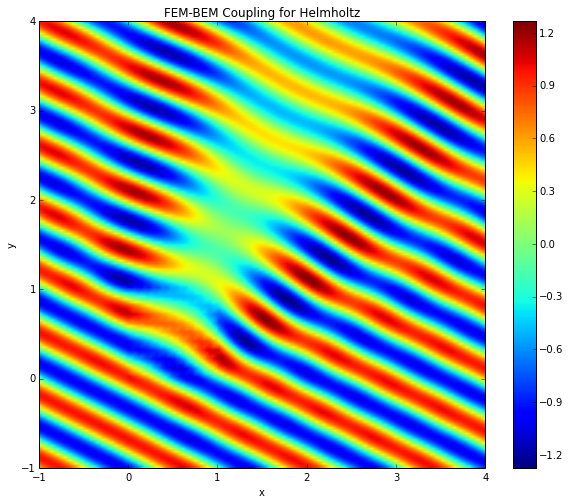

In [47]:
# The next command ensures that plots are shown within the IPython notebook
%matplotlib inline

Nx=150
Ny=150
xmin,xmax,ymin,ymax=[-1,4,-1,4]
plot_grid = np.mgrid[xmin:xmax:Nx*1j,ymin:ymax:Ny*1j]
points = np.vstack((plot_grid[0].ravel(),plot_grid[1].ravel(),np.array([0.5]*plot_grid[0].size)))
plot_me = np.zeros(points.shape[1],dtype=np.complex128)

x,y,z=points
bem_x = np.logical_not((x>0)*(x< 1)*(y > 0)*(y < 1)*(z > 0)*(z< 1))

from bempp.operators.potential import helmholtz as helmholtz_potential
slp_pot=helmholtz_potential.single_layer(bempp_space,points[:,bem_x],k)
dlp_pot=helmholtz_potential.double_layer(trace_space,points[:,bem_x],k)

plot_me[bem_x] += np.exp(1j*k*(points[0,bem_x]*d[0]+points[1,bem_x]*d[1]+points[2,bem_x]*d[2]))
plot_me[bem_x] += dlp_pot.evaluate(g_soln)[0]
plot_me[bem_x] -= slp_pot.evaluate(g_n_soln)[0]

fem_points = points[:,np.logical_not(bem_x)].transpose()
fem_val = np.zeros(len(fem_points))
for p,point in enumerate(fem_points):
    result = np.zeros(1)
    u.eval(result,point)
    fem_val[p] = result[0]

plot_me[-bem_x] += fem_val

plot_me = plot_me.reshape((Nx,Ny))

plot_me = plot_me.transpose()[::-1]

# Plot the image
from matplotlib import pyplot as plt
fig=plt.figure(  figsize =(10, 8))
plt.imshow(np.real(plot_me),extent=[xmin,xmax,ymin,ymax])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title("FEM-BEM Coupling for Helmholtz")
plt.show()